In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import F1Score
from tqdm import tqdm

BATCH_SIZE = 32
EPOCHS = 10
DATA_DIR = 'preprocessed_brain_mri_dataset'

Loading pituitary: 100%|████████████████████████████████████████████████████████████| 667/667 [00:00<00:00, 756.61it/s]


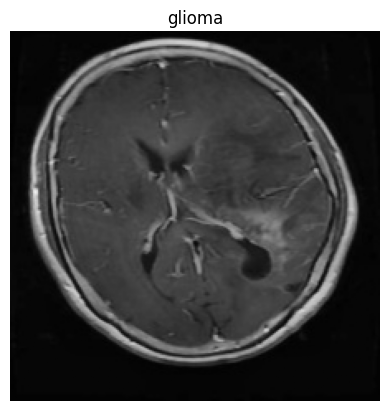

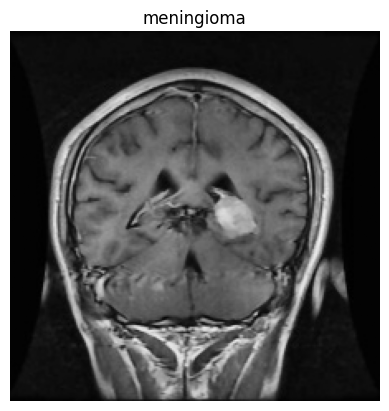

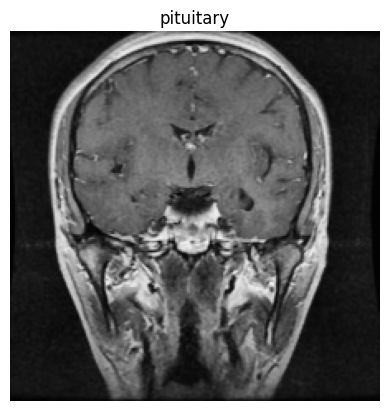

In [3]:
images = []
labels = []

abnormal_classes = ['glioma', 'meningioma', 'pituitary']

# Load abnormal images and undersample each class to 667
for idx, label in enumerate(abnormal_classes):
    folder = os.path.join(DATA_DIR, label)

    img_names = [f for f in os.listdir(folder) if f.lower().endswith('.jpg')]
    img_names = shuffle(img_names, random_state=42)[:667]

    for img_name in tqdm(img_names, desc=f'Loading {label}'):
        img_path = os.path.join(folder, img_name)
        img = load_img(img_path, target_size=(224,224))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(idx)  # label index corresponds to class

# Convert to numpy arrays and one-hot encode labels
images = np.array(images)
labels = tf.keras.utils.to_categorical(labels, num_classes=len(abnormal_classes))

# Show example images from each class
for idx, label in enumerate(abnormal_classes):
    sample_img = images[labels[:, idx] == 1][0]
    plt.imshow(sample_img)
    plt.title(label)
    plt.axis("off")
    plt.show()


In [4]:
img_input = layers.Input(shape=(224,224,3))
base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)
base.trainable = False

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(len(abnormal_classes), activation='softmax')(x)

model = Model(inputs=img_input, outputs=output)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.F1Score(average='macro')]
)

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

C:\Users\user\AppData\Local\Temp\ipykernel_22512\2260958424.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 468ms/step - accuracy: 0.6938 - f1_score: 0.6906 - loss: 0.6899 - precision: 0.7323 - recall: 0.6481 - val_accuracy: 0.7930 - val_f1_score: 0.7730 - val_loss: 0.4399 - val_precision: 0.8157 - val_recall: 0.7506
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - accuracy: 0.8394 - f1_score: 0.8389 - loss: 0.4112 - precision: 0.8474 - recall: 0.8225 - val_accuracy: 0.8728 - val_f1_score: 0.8726 - val_loss: 0.3584 - val_precision: 0.8807 - val_recall: 0.8653
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 409ms/step - accuracy: 0.8487 - f1_score: 0.8472 - loss: 0.3542 - precision: 0.8631 - recall: 0.8356 - val_accuracy: 0.8853 - val_f1_score: 0.8864 - val_loss: 0.3068 - val_precision: 0.8866 - val_recall: 0.8778
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 416ms/step - accuracy: 0.8831 - f1_score: 0.8826 - loss: 0.2958 - precision: 0.8873 - recall: 0.8756 - val_accuracy: 0.9052 - val_f1_score: 0.9055 - val_loss: 0.2756 - val_precision: 0.9073 - val_rec

In [5]:
# Keras and h5 format
model.save('downloaded_models/mobilenetv2/multi_classifier_preprocessed/multi_brain_mri_model.h5')
model.save('downloaded_models/mobilenetv2/multi_classifier_preprocessed/multi_brain_mri_model.keras')

# TensorFlow SavedModel format (folder)
model.export('downloaded_models/mobilenetv2/multi_classifier_preprocessed/multi_brain_mri_model_folder')

INFO:tensorflow:Assets written to: downloaded_models/mobilenetv2/multi_classifier/multi_brain_mri_model_folder\assets


INFO:tensorflow:Assets written to: downloaded_models/mobilenetv2/multi_classifier/multi_brain_mri_model_folder\assets


Saved artifact at 'downloaded_models/mobilenetv2/multi_classifier/multi_brain_mri_model_folder'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2403536386576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2403952281552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2403952281744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2403952279632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2403952281168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2403536386768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2403952280784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2403952282704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2403952282512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2403952282128: TensorSpec(shape=(), dtype=t